# <center>Special lecture 1: min-cost flow problems</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass on optimal transport and economic applications</center>
#### <center>With python code examples</center>
© 2018-2022 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/theteam).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass on optimal transport and economic applications, January 2022. https://github.com/math-econ-code/mec_optim

### Learning Objectives 

* Basic concepts of directed networks

* The min-cost flow problem

* Duality, optimality and equilibrium

### References

* Galichon, *Optimal Transport Methods in Economics*. Ch.8.

* Tolstoi (1930). Methods of finding the minimal total kilometrage in cargo transportation planning in space. *Transportation Planning* [in Russian]

* Koopmans (1949). Optimum utilization of the transportation system. *Econometrica*.

* Schrijver (2002). On the History of the Transportation and Maximum Flow Problems. *Mathematical programming*.

## Motivation

### Motivation: network flow problems

In 1930 Tolstoi, a Russian engineer, has to optimize the shipping of cement from factories to cities in the Soviet union through railway.

* each factory produces a fixed number of tons

* each city needs a fixed number of tons -- for now, we'll assume total production=total consumption

* each factory is connected by rail with a few cities, and the corresponding distance is given

* how to ship in order to minimize the total distance travelled?

This problem belongs to the class of *min-cost flow problems*, an important class of linear programming problems, which are the focus of today's lecture. A decade before the invention of linear programming and the work of Kantorovich, Koopmans and Dantzig, Tolstoi described a heuristic method for solving the problem, which led to the optimal solution. As one can recover using modern tools, and will see that his solution was right.

The *shortest path problem*, or how to find the path of minimal distance from a point to another in a network, also belongs in this class. 

Fist, let's load libraries we'll need. We'll need `os` and `pandas` for data importation and manipulations, `numpy` and part of `scipy` for computations, `gurobipy` for linear programming using Gurobi, `osmnx` to import map data from [OpenStreetMap](https://www.openstreetmap.org/), `networkx` for operations on networks, parts of `matplotlib` for displays,  


In [28]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
import osmnx as ox
import networkx as nx
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# !python -m pip install -i https://pypi.gurobi.com gurobipy ## only if Gurobi not here
import gurobipy as grb



#thepath = os.path.join(os.getcwd(),'data_mec_optim/')
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/'


# A look at our data

We will be looking at 3 types of data, which we each briefly describe.



## Soviet Planning Problem

Tolstoi's original data, collected by Schrijver (2002). There are 68 Soviet cities and 10 factories, and 155 links connecting a factory to a city. This yields a sparse $68\times10$ matrix. Two vectors listing the demand of each city and the supply of each factory are also specified. This is stored in a $69\times11$ matrix, where we have appended the demand/supply vectors to the right and to the botton of the distance matrix.

We read the data and display it.

In [2]:
soviet_df = pd.read_csv(thepath+'networks_sovietplanning/distances.csv', sep=',',encoding = "ISO-8859-1")

soviet_df

,X,Arkhangelsk,Yaroslavl,Murom,Balakhonikha,Dzerzhinsk,Kishert,Sverdlovsk,Artemovsk,Iledzhk,Dekonskaya,demand:
0,Agryz,NaN,NaN,NaN,709.0,1064.0,693.0,NaN,NaN,NaN,NaN,2.0
1,Aleksandrov,NaN,NaN,NaN,NaN,397.0,NaN,NaN,1180.0,NaN,NaN,4.0
2,Almaznaya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,65.0,1.5
3,Alchevskaya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,114.0,4.0
4,Baku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1554.0,NaN,1563.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
64,Shchigry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.0,NaN,549.0,4.0
65,Yudino,NaN,NaN,NaN,403.0,757.0,999.0,NaN,NaN,NaN,NaN,0.5
66,Yama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,52.0,5.0
67,Yasinovataya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,93.0,6.0


Plants and cities are the *nodes* of our network. 
There are *arcs* directly connecting when there is a railway from the plant to the city. In that case, the entry of the corresponding cell is equal to the length of the arc. When there is none, the corresponding cell shows `NaN`.
We will index the nodes from to `nbPlants+nbCities`, with the plants being indexed by 0,1,...`nbPlants-1`, and the cities being indexed by `nbPlants`, `nbPlants+1`, ... , `nbPlants+nbCities`.
Let us collect the arcs and their corresponding distances.



In [3]:
nbPlants = soviet_df.shape[1]-2
nbCities = soviet_df.shape[0]-1
arcsList = []
costslist = []
nodesList = [soviet_df.columns.values[plant+1]+' Plant' for plant in range(nbPlants)] + [soviet_df.iloc[city,0]+' city' for city in range(nbCities)]
for plant in range(nbPlants):
    for city in range(nbCities):
        if not pd.isna(soviet_df.iloc[city,plant+1]):
            #arcsList.append((plant,nbPlants+city))
            arcsList.append((nodesList[plant],nodesList[nbPlants+city]))
            costslist.append(soviet_df.iloc[city,plant+1])
nodesList = [soviet_df.columns.values[plant+1]+' Plant' for plant in range(nbPlants)] + [soviet_df.iloc[city,0]+' city' for city in range(nbCities)]

We will create a class `network_problem` to collect and story the relevant information we need: nodes, arcs, and arcs length. We will add methods later.

In [4]:
class network_problem:
    def __init__(self,nodesList,arcsList,costsList):
        self.nbNodes = len(nodesList)
        self.nbArcs = len(arcsList)
        self.nodesList = nodesList
        self.arcsList = arcsList
        self.costsList = costsList
        self.nodesDict = {node:node_ind for (node,node_ind) in zip(self.nodesList,range(self.nbNodes))}
        self.arcsDict = {arc:arc_ind for (arc,arc_ind) in zip(self.arcsList,range(self.nbArcs))}
        print('Number of nodes='+str(self.nbNodes)+'; number of arcs='+str(self.nbArcs)+'.')

soviet_pb = network_problem(nodesList,arcsList,costslist) 

Number of nodes=78; number of arcs=155.


## NYC subway network

NYC subway network data: the network data are available on http://www.mta.info. This data is made of two files. The file `nodes.csv` lists the stations: each station is indexed by the line number; each line has the name of the station, and its spatial coordinates. The file `arcs.csv` lists the links between stations: each link specifies the index of the origin, the index of the destination, and the length of the segment. 

We shall store this information in a `network_problem` object called `subway_pb`.

In [29]:
arcs = pd.read_csv(thepath+'networks_subway/NYC/arcs.csv', sep=',')#.sort_values(by=['route_id'])
nodes = pd.read_csv(thepath+ 'networks_subway/NYC/nodes.csv', sep=',')
stopnames = [i+' '+j for i,j in zip(nodes.stop_name,nodes.route_id)]
arcsList = [(stopnames[o-1],stopnames[d-1]) for (o,d) in list(zip(arcs.from_stop_nb,arcs.to_stop_nb))]
subway_pb = network_problem(stopnames,arcsList,list(arcs.dis_line)) 

Number of nodes=501; number of arcs=1290.


Stations' caracteristics are contained in `nodes` dataframe. The relevant information for us will be the name of the station, the horizontal spatial coordinate, and the vertical coordinates.

In [30]:
nodes.head(3)

,stop_name,flow,stop_lat,stop_lon,stop_id,stop_nb,route_id
0,Van Cortlandt Park - 242 St,1000,40.889248,-73.898583,101,1,(1)
1,238 St,1000,40.884667,-73.900870,103,2,(1)
2,231 St,1000,40.878856,-73.904834,104,3,(1)


Routes between stations are contained in `arcs` dataframe--the first column is the origin node, the second one is the destination node, and the third one is the length of the arc in meters. 

In [7]:
arcs.head(3)

,from_stop_nb,to_stop_nb,dis_line,min_time_elapsed,from_stop_id,to_stop_id,route_id
0,185,10,15000.0,0.18,A09,112,NaN
1,198,23,15000.0,0.18,A24,125,NaN
2,448,25,15000.0,0.18,R16,127,NaN


## Paris streets

Next, we gather data on the network of the Paris streets. To to this, we use the `osmnx` package to retrieve data from [OpenStreetMap](https://www.openstreetmap.org/). Doing this is as simple as specifying an address, and calling the `graph_from_address` function, specifying the desired distance (in meters) around this address. 

<IPython.core.display.Javascript object>


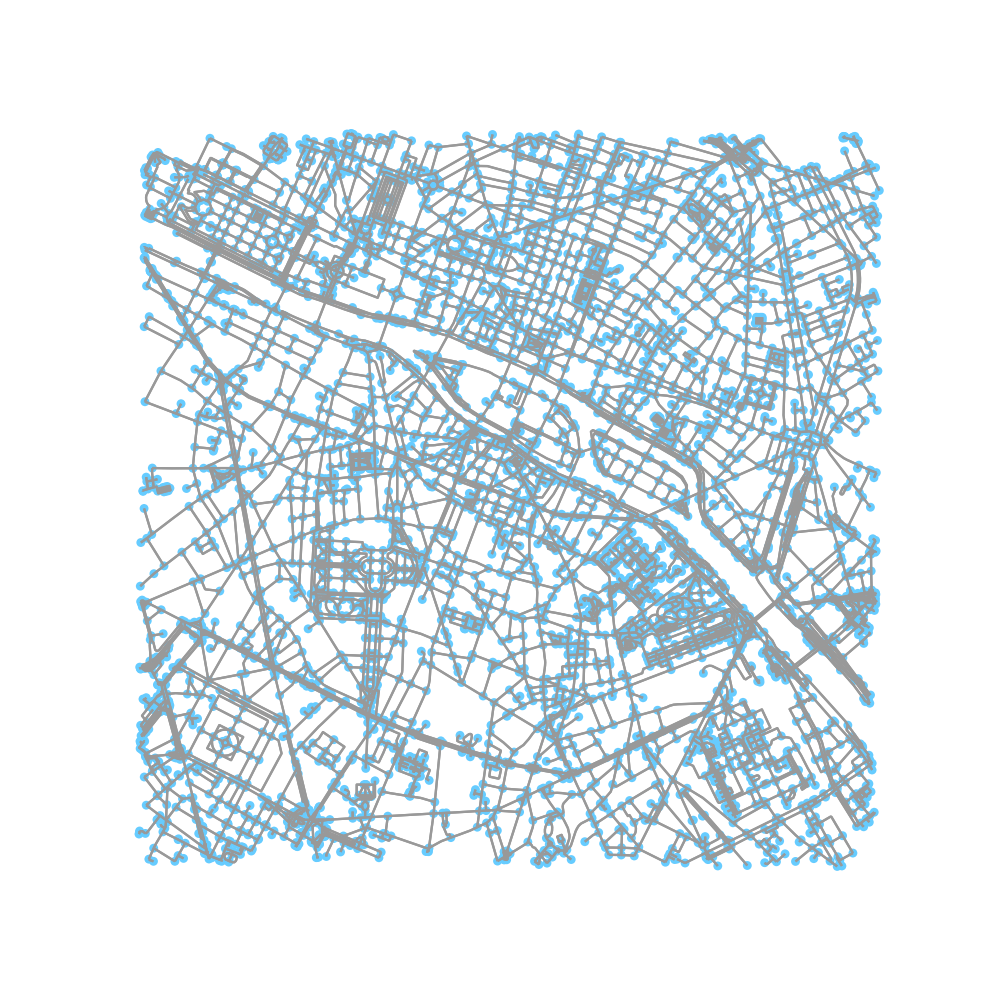

(<Figure size 602.1x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2096fce2948>)

In [33]:
nyu_address='57 boulevard Saint-Germain, 75005 Paris, France'
streets_network = ox.graph.graph_from_address(nyu_address, dist=2000,network_type = 'walk')
ox.plot_graph(ox.project_graph(streets_network))

As we see, the essential information we can extract from the graph is the list of nodes (`nodes_roads` below) and the list of arcs (`arcs_roads` below).

In [9]:
arcslist = [(i,j) for (i,j,k) in list(streets_network.edges)]
costslist = [streets_network[i][j][0]["length"] for i,j in arcslist ]
streets_pb = network_problem(list(streets_network.nodes),arcslist,costslist) 

Number of nodes=7033; number of arcs=19860.


Now that we have the structure of the data in mind, let's develop the conceptual tools we shall need in our analysis.

## Topology of networks

### Directed graph

We start by defining the directed graph on which transportation takes place.

---
**Definition**

A (directed) *graph* $\left(\mathcal{Z},\mathcal{A}\right)$ is a set of *nodes* (cities) $\mathcal{Z}$, along with a set of *arcs* $\mathcal{A}\subseteq\mathcal{Z}^{2}$ which are pairs $\left(x,y\right)$ where $x\neq y\in\mathcal{Z}$.

---
Our definition does not allow for an arc to have the same origin and destination. Note that for a dense network, $\left\vert \mathcal{A} \right\vert = \left\vert \mathcal{Z}\right\vert\left( \left\vert \mathcal{Z}\right\vert - 1 \right)$. For a line, $\left\vert \mathcal{A}\right\vert =\left\vert \mathcal{Z}\right\vert -1$.

**Stylized example**. Take the following example, which we shall use for exposition purposes:

In [27]:
example_graph = nx.DiGraph()
arcslist = [('s','u'),('u','v'),('s','v'),('u','t'),('v','t')]
costslist = [3,1,4,2,2]
example_graph.add_edges_from(arcslist)

example_pb = network_problem(list(example_graph.nodes),arcslist,costslist) 

pos = {'s':np.array([0,0]),'u':np.array([1,0.5]),'v':np.array([2,0]),'t':np.array([3,0])} 
nx.draw_networkx_edge_labels(example_graph,pos,edge_labels={e:('c='+str(l)) for (e,l) in zip(arcslist,costslist)},font_color='red')
nx.draw(example_graph,pos,with_labels=True)
plt.show()

Number of nodes=4; number of arcs=5.


### Gradient matrix

Next, we define the gradient matrix, which encodes the information contained in the directed graph.

---
**Definition**
<a name="grad_mat"></a>

We define the *gradient matrix* (also called an `edge-node matrix') as the matrix with general term $\nabla_{ax}$, $a\in\mathcal{A}$, $x\in \mathcal{Z}$, such that

\begin{align*}
\nabla_{ax}  &  =-1\text{ if }a\text{ is out of }x\text{,}\\
&  =+1\text{ if }a\text{ is into }x\text{,}\\
&  =0\text{ else.}
\end{align*}

---

Hence, if $f\in\mathbb{R}^{\mathcal{Z}}$, then $\nabla f\in\mathbb{R}^{\mathcal{Z}}$, and $\left(  \nabla f\right)  _{xy}=f_{y}-f_{x}$.

We shall denote $\nabla^{\intercal}$ the transpose of the gradient matrix. It is the network analog of the $-\operatorname{div}$ differential operator.


From the list of arcs, now we can easily construct our $\nabla$ matrix, as the first component of each element of `arcs` is the origin node (which will have $-1$ entry in $\nabla$) and the second component is the destination nodes (which will have $+1$ entry). 
An important feature of the matrix $\nabla$ is *sparsity*: for each row (arcs), there are only two nonzero terms. We should recognize this sparse structure and code $\nabla$ as a sparse matrix. In `scipy`, this is done using `csr_matrix`. 
We implement this as follows:

In [11]:
def Nabla(self):
    data = np.concatenate([-np.ones(self.nbArcs),np.ones(self.nbArcs)])
    arcsIndices = list(range(self.nbArcs))
    arcsOrigins = [self.nodesDict[o] for o,d in self.arcsList]
    arcsDestinations = [self.nodesDict[d] for o,d in self.arcsList]
    theNabla = sp.csr_matrix((data, (arcsIndices+arcsIndices, arcsOrigins+arcsDestinations)), shape = (self.nbArcs,self.nbNodes))
    return(theNabla)

network_problem.Nabla = Nabla

If we want to visualize, we need to convert it to a `np.array` matrix using the `.toarray()` method. 

**Stylized example**. In the case of our example, the matrix looks like the following:

In [12]:
example_pb.Nabla().toarray()

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [-1.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  1.],
       [ 0.,  0., -1.,  1.]])

Take the first line in the example above, for instance, which is associated with the `uv` arc. It has a $-1$ entry on the first column entry (indicating leaving the node `u`), and a $+1$ entry on the second column entry (indicating entering the node `v`).

### Paths and loops

Next, we define the terms *paths* and *loops*.

---
**Definition**

Given two nodes $x$ and $y$, a *path* from $x$ to $y$ is a sequence $z_{1},z_{2},...,z_{K}$ in $\mathcal{Z}$ where $z_{1}=x$, $z_{K}=y$, and for every $1\leq k\leq K-1$, $\left(  z_{k},z_{k+1}\right)  \in\mathcal{A}$.


A *loop* (also called `cycle') is a path from a node $x$ to itself.

---

**Stylized example**. In our stylized example, `(s,u,v,t)` is a path, but `(s,v,u,t)` is not a path.

### Transportation costs

A vector $c\in\mathbb{R}^{\mathcal{A}}$ defines transportation costs. That is, for $xy\in\mathcal{A}$, $c_{xy}$ is the transportation cost associated to arc $xy$. $c$ can also be thought of as the length of arc $xy$. The cost of moving the good from node $x$ to node $y$ along path $z_{1},z_{2},...,z_{K}$ is

\begin{align*}
\sum_{k=1}^{K-1}c_{z_{k}z_{k+1}}.
\end{align*}

## Assumptions about the network

We shall introduce a number of natural assumptions about the network.

### No profitable loop
---
**Assumption** [No profitable loop]
<a name="noprofitloop"></a>

There is no profitable loop, which means that there is no sequence $z_{1},...,z_{K}$ in $\mathcal{Z}$ such that $z_{K}=z_{1}$, $\left(  z_{k},z_{k+1}\right)  \in\mathcal{A}$, and $\sum_{k=1}^{K-1}c_{z_{k}z_{k+1}}<0$.

---

In particular, there is no profitable loop if $c\geq0$.

### Balancedness
Let $q_{z}$ be the *net demand* at node $z \in \mathcal{Z}$, which is the quantity of goods disappearing from the graph. The set of nodes defined by

\begin{align*}
\mathcal{Z}_{0}=\left\{  x\in\mathcal{Z}:q_{x}<0\right\}  \text{, and }\mathcal{Z}_{1}=\left\{  y\in\mathcal{Z}:q_{y}>0\right\}
\end{align*}

are called the *supply nodes* and *demand nodes* respectively. A node which is neither a supply node, neither a demand node is called a *transit node*.

Total supply is $-\sum_{x\in\mathcal{Z}_{0}}q_{x}$, total demand is $\sum_{y\in\mathcal{Z}_{1}}q_{y}$.

---
**Assumption** [Balancedness] 
<a name="balancedness"></a>

Assume that total supply equals total demand on the network, that is

\begin{align*}
\sum_{x\in\mathcal{Z}_{0}}q_{x}+\sum_{y\in\mathcal{Z}_{1}}q_{y}=0.
\end{align*}

---

### Connectedness

---
**Assumption** [Connectedness]
<a name="connectedness"></a>

Assume the set of supply nodes $\mathcal{Z}_{0}$ is *strongly connected* to the set of demand nodes $\mathcal{Z}_{1}$, i.e. for every $x\in\mathcal{Z}_{0}$ and $y\in \mathcal{Z}_{1}$, there is a path from $x$ to $y$.

---


### Regular networks

The specification of the graph, the net demand vector, and the surplus vector
defines a network.

---
**Definition**

A directed graph $\left(\mathcal{Z},\mathcal{A}\right)$ endowed with a net demand vector $\left(n_{z}\right)_{z \in \mathcal{Z}}$ and a cost vector $\left(c_{a}\right)_{a\in\mathcal{A}}$ is called a *network* $\left(\mathcal{Z}, \mathcal{A}, q, c\right)$. If the three assumptions above: [no profitable loop](#noprofitloop), [balancedness](#balancedness) and [connectedness](#connectedness) all hold, the network is called *regular*.

---

Without mention of the contrary we shall assume that the network under consideration is regular.


### Flows and feasible flows

A *flow* is a vector $\mu$ on $\mathbb{R}_+^{\mathcal{A}}$, where $\mu_a$ is the quantity of mass passing through arc $a$.

The flow of mass disappearing at $z$ equals the flow arriving from other nodes minus the flow shipping to other nodes

\begin{align*}
q_{z}=\sum_{x:xz \in\mathcal{A}}\mu_{xz}-\sum_{y:zy \in\mathcal{A}}\mu_{zy}
\end{align*}

and this equation can be rewritten as $\nabla^{\intercal}\mu=n$. This motivates the following definition:

---
**Definition**

The set of feasible flows associated with $q$, denoted $\mathcal{M}\left(  q\right)$, or $\mathcal{M}$ when there is no ambiguity, is defined as the set of flows $\mu\geq0$ that verify conservation equation

\begin{align*}
    \nabla^{\intercal}\mu=q.
\end{align*}

---


**Stylized example**. In our stylized example, the flow of mass $\mu$ associated with arc `(s,u,v,t)` has one unit of mass on arcs `su`,`uv`, and `vt`. Hence,  $\nabla ^\top \mu$ is: 

In [13]:
# example_pb.arcsList
# example_pb.nodesList
mu = np.array([1,1,0,0,1])
(example_pb.Nabla().transpose() * mu.reshape(-1,1)).reshape(1,-1)

array([[-1.,  0.,  0.,  1.]])

We see that the vector of exiting flows $\nabla ^\top \mu$ is equal to $-1$ on arc `s`, equal to $1$ on arc `t`, and equal to zero elsewhere. Mass ''appears'' at the start of the path `s`, ''disappears'' at the end of the path `t`, and is conserved along the path and elsewhere in the network.  

Conversely, if $q_z = 1\{z=t\} - 1\{z=s\}$, and for $\mu\in\mathcal{M}(q)$, one may find a path from `s` to `t` along the support of $\mu$, by the following simple algorithm, which consists of looking for an arc in the support of $\mu$ originating at the current node, replacing the current node by the destination of the arc, and deleting the arc. It is easy to see that this algorithm will get from `s` to `t` in a finite number of steps. We implement it below: 

In [31]:
def pathfinder(self,mu,sind,tind):
    # assume mu is such that $\Nabla^\top \mu =1 on t, =-1 on s, and =0 elsewhere
    t = self.nodesList[tind]
    arcs_active = [(x,y) for (x,y) in self.arcsList if (mu[self.arcsDict[(x,y)]] > 0) ]
    current = self.nodesList[sind]
    path = [current]
    while current != t:
        (x,y) = next((x,y) for (x,y) in arcs_active if x==current)
        path.append(y)
        current = y
        arcs_active.remove((x,y))
    return(path)
    

network_problem.pathfinder = pathfinder

**Stylized example**. We run this in our stylized example, to determine a path associated with `mu = np.array([1,1,0,0,1])` from `s`to `t`. We get:

In [15]:
example_pb.pathfinder(mu,0,3)

['s', 'u', 'v', 't']

## The min-cost flow problem

Let $p_{z}$ be the price of the commodity at $z$. Consider the strategy which consists in purchasing the good at $x$, shipping to $y$, and selling at $y$. The profit of this strategy is

\begin{align*}
p_{y}-p_{x}-c_{xy}=\left(  \nabla p-c\right)_{xy}
\end{align*}

and hence there is no arbitrage opportunity if $p_{y}-p_{x}-c_{xy}\leq0$ for every arc $xy$, that is

\begin{align*}
\nabla p\leq c.
\end{align*}

Consider the *minimum cost flow problem*
<a name="primal"></a>
\begin{align*}
&  \min_{\mu\geq0}\sum_{\left(  x,y\right)  \in\mathcal{A}}\mu_{xy}%
c_{xy} \\
&  s.t.~\nabla^{\intercal}\mu=q
\end{align*}

which is a linear programming problem whose dual is
<a name="dual"></a>
\begin{align*}
&  \max_{p\in\mathbb{R}^{\mathcal{Z}}}\sum_{z\in\mathcal{Z}}p
_{z} q_{z}\\
&  s.t.~\nabla p\leq c.
\end{align*}


## Min-cost flow duality

---
**Proposition**
1. Under Assumption [No profitable loop](#noprofitloop), the [dual problem](#dual) is feasible, which means that there is a vector $p\in\mathbb{R}^{\mathcal{Z}}$ such that $\nabla p\leq c$; and the value of [primal problem](#primal) is strictly less than $+\infty$.

2. Under Assumptions [balancedness](#balandedness) and [connectedness](#connectedness), the [primal problem](#primal) is feasible, which means that there is a flow $\mu\geq0$ such that $\nabla^{\intercal}\mu=q$; and the value of [dual problem](#dual) is strictly greater than $-\infty$.

---

Assume that $\left(\mathcal{Z},\mathcal{A},q,c\right)$ is a regular network. Then the value of the [primal problem](#primal) coincides with the value of its [dual](#dual), and both problems have solutions. Further, if $\mu$ is a solution to the primal and $p$ is a solution to the dual, then $\mu_{xy}>0$ implies $p_{y}-p_{x}=c_{xy}$.

In [16]:
def network_problem_mincostflow(self,q,OutputFlag=True):
    Nabla = self.Nabla()
    m=grb.Model()
    m.setParam('OutputFlag', OutputFlag)
    p = m.addMVar(shape=self.nbNodes, name="p", lb = float('-inf'))
    m.setObjective(q @ p, grb.GRB.MAXIMIZE)
    m.addConstr( Nabla @ p <= np.array(self.costsList))
    m.optimize()
    if m.status == grb.GRB.Status.OPTIMAL:
        p_z = m.getAttr('x')
        mu_a = m.getAttr('pi')
    return np.array((p_z,mu_a),dtype=object)

network_problem.mincostflow =  network_problem_mincostflow

# Special cases

## Shortest path problem

Assume there is only one source node $s \in \mathcal{Z}$ and one target node $t\in\mathcal{Z}$, each associated with unit flow. That is, $q_{z}=1\left\{  z=t\right\}  -1\left\{  z=s\right\}$. Then the problem boils down to how to push one unit of mass from $s$ to $t$. If we interpret $c_{xy}$ as the distance along arc $xy$, the solution of this problem corresponds to the shortest path from $s$ to $t$. This is why this problem is called shortest path problem. (More generally, this problem extends to the case when $c$ does not have a negative loop).

The dual problem is then

\begin{align*}
\max_{p}  &  ~p_{t}-p_{s}\\
s.t.  &  ~p_{y}-p_{x}\leq c_{xy}~\forall xy\in\mathcal{A}
\end{align*}

and we can impose normalization $p_{s}=0$, so that along the travelled path, $p_{z}$ interprets as the distance travelled thus far.

**Stylized example**. We run the min-cost flow problem in its ''shortest path'' version on our stylized example, with origin at node `s` and destination at node `t`.

In [17]:
p_z,mu_a = example_pb.mincostflow(np.array([[-1.,  0.,  0.,  1.]]))
print('\np_z='+str(p_z)+', and \nμ_a ='+str(mu_a) )
#example_pb.arcsList
example_pb.pathfinder(mu_a,0,3)

Using license file C:\Users\Alfred\gurobi.lic
Academic license - for non-commercial use only
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0x930d4ce3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   0.000000e+00   2.000000e-06      0s

Solved in 0 iterations and 0.06 seconds
Optimal objective  5.000000000e+00

p_z=[-3.0, 0.0, 0.0, 2.0], and 
μ_a =[1.0, 0.0, 0.0, 1.0, -0.0]


['s', 'u', 't']

We see that the shortest path in the sytlized example is `sut`, with a total cost of 5.

**NYC subway dataset**. We now move on to the subway dataset, where we are trying to find the shortest path NYU to Columbia.

In [18]:
def network_problem_shortestPathLP(self,origin_node,destination_node, OutputFlag = True):
    q = np.zeros(self.nbNodes)
    q[origin_node] = -1
    q[destination_node] = 1
    p_z,mu_a = self.mincostflow(q,OutputFlag)
    return self.pathfinder(mu_a,origin_node,destination_node)

network_problem.shortestPathLP = network_problem_shortestPathLP

In [32]:
orig, dest = subway_pb.nodesDict['8 St - NYU (N/R)'] ,subway_pb.nodesDict['116 St - Columbia University (1)']
subway_pb.shortestPathLP(orig,dest )

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 1290 rows, 501 columns and 2580 nonzeros
Model fingerprint: 0x260ab643
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+04]
Presolve removed 1132 rows and 305 columns
Presolve time: 0.02s
Presolved: 158 rows, 353 columns, 778 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     148    2.3979662e+04   0.000000e+00   0.000000e+00      0s

Solved in 148 iterations and 0.04 seconds
Optimal objective  2.397966180e+04


['8 St - NYU (N/R)',
 '14 St - Union Sq (N/R/Q)',
 '34 St - Herald Sq (Q/N)',
 'Times Sq - 42 St (R/Q)',
 'Times Sq - 42 St (1/3)',
 '72 St (1/2)',
 '96 St (2/1/3)',
 '103 St (1)',
 'Cathedral Pkwy (1)',
 '116 St - Columbia University (1)']

**Paris streets dataset**. We shall now look for the shortest path between the centers of NYU and Columbia in Paris through the pedestrian network on the Parisian streets. First, let us use `osmnx`'s function `geocode` to convert the addresses into geographic coordinates, and then `get_nearest_node` to find the two nearest nodes on the network.

In [20]:
nyu_geocode  = ox.geocode('57 boulevard Saint-Germain, 75005 Paris, France') # NYU Paris
columbia_geocode = ox.geocode('4 Rue de Chevreuse, 75006 Paris') # Columbia in Paris
orig = streets_pb.nodesDict[ox.get_nearest_node(streets_network, nyu_geocode)]
dest = streets_pb.nodesDict[ox.get_nearest_node(streets_network, columbia_geocode)]

In [21]:
path = streets_pb.shortestPathLP(orig,dest, OutputFlag = False)

We determine the minumum cost flow using Gurobi, and obtain the shortest path accordingly:

We can plot the shortest path using `osmnx`'s `plot_graph_route` function.

<IPython.core.display.Javascript object>


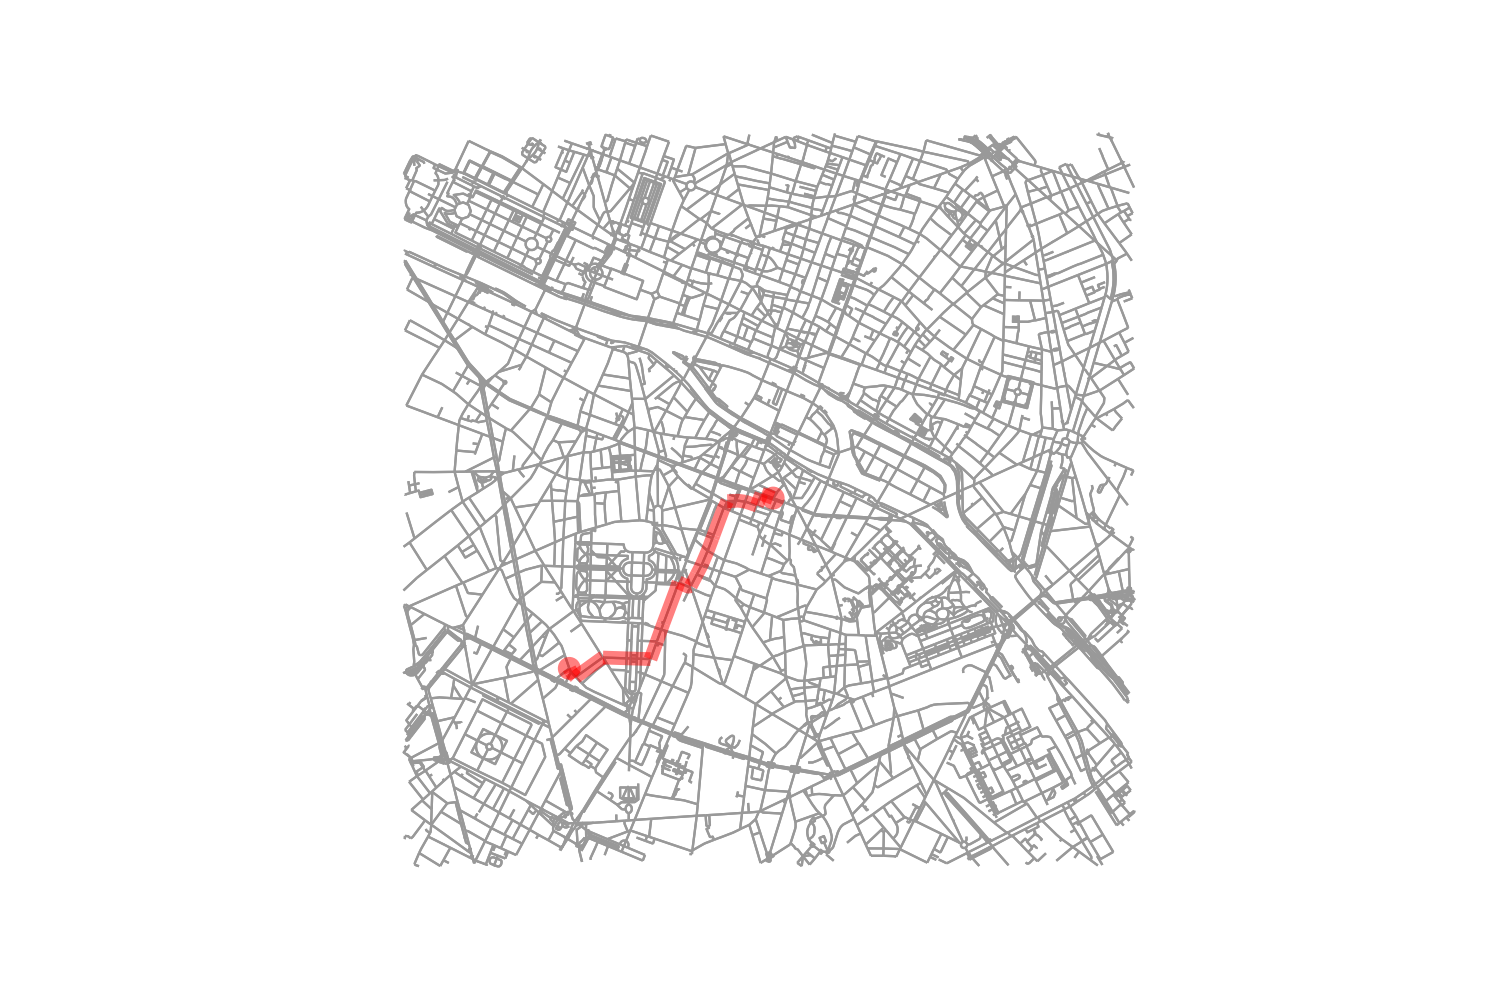

In [22]:
fig, ax = ox.plot_graph_route(streets_network, path, route_linewidth=6, node_size=0, bgcolor='k')

### Shortest path via dynamic programming

We have advocated for the use of Gurobi as a black box in this problem, but there exists a direct method to find out the minimal cost path, using dynamic programming.

The crucial remark here is that if there is a minimal cost path from $s$ to $t$, then there is one of length at most $\left\vert \mathcal{Z}\right\vert - 1$.

For $z\in\mathcal{Z}$, and $t\in\mathbb{N}$, let $C_{sz}^{k}$ be the minimal cost of the path from $s$ to $z$ among paths of length at most $k$, with the convention that $C_{sz}^{k}=+\infty$ if there is no such path. One has:

* $C_{ss}^{0}=0$ and $C_{sz}^{0}=+\infty$ for all $z\neq s$, and

* for $t\geq1$, $C_{sz}^{k}$ satisfies the Bellman equation:

\begin{align*}
C_{sz}^{k}=\min\left\{  C_{sz}^{k},\min_{x\in\mathcal{Z}:sz\in\mathcal{A}%
}\left\{  c_{sx}+C_{xz}^{k-1}\right\}  \right\}  .
\end{align*}

It is easy to see that $C_{st}^{\left\vert \mathcal{Z}\right\vert }$ is the minimal cost of any path from $s$ to $t$. Shortest-paths algorithms (Dijikstra and Bellman-Ford) implement this idea.

In `networkx`, this is implemented using:

In [23]:
path_bis = nx.shortest_path(streets_network,streets_pb.nodesList[orig], streets_pb.nodesList[dest], weight='length')
path == path_bis

True

We can also translate the above idea into code and recover the shortest path from NYU to Columbia through the NYU subway network.

In [24]:
def network_problem_shortestPathDP(self,origin_node,destination_node, OutputFlag = True):
    successor = {z: None for z in self.nodesList}
    C_x_y = np.inf * np.ones((self.nbNodes,self.nbNodes))
    d_xy = np.array(self.costsList)
    C_x_y[destination_node,destination_node] = 0
    delta_x_y = np.zeros((self.nbNodes,self.nbNodes))
    update = True
    while update:
        update = False
        for x,y in self.arcsList:
            xind,yind = self.nodesDict[x],self.nodesDict[y]
            if d_xy[self.arcsDict[(x,y)] ] +  C_x_y[yind, destination_node]  < C_x_y[xind,destination_node]:
                update = True
                C_x_y[xind,destination_node] = d_xy[self.arcsDict[(x,y)] ] +  C_x_y[yind, destination_node]
                successor[x]=y

    z = self.nodesList[origin_node]
    path = [z]
    while (successor[z] != self.nodesList[destination_node]):
        z = successor[z] 
        path.append(z)
    path.append(self.nodesList[destination_node])
    if OutputFlag == True:
        print("Cost = ",C_x_y[origin_node,destination_node])
    return path

network_problem.shortestPathDP = network_problem_shortestPathDP

In [34]:
orig, dest = subway_pb.nodesDict['8 St - NYU (N/R)'] ,subway_pb.nodesDict['116 St - Columbia University (1)']
subway_pb.shortestPathDP(orig,dest )

Cost =  23979.661803262097


['8 St - NYU (N/R)',
 '14 St - Union Sq (N/R/Q)',
 '34 St - Herald Sq (Q/N)',
 'Times Sq - 42 St (R/Q)',
 'Times Sq - 42 St (1/3)',
 '72 St (1/2)',
 '96 St (2/1/3)',
 '103 St (1)',
 'Cathedral Pkwy (1)',
 '116 St - Columbia University (1)']

## Transportation problem

Assume the problem is bipartite, that is $\mathcal{Z}=\mathcal{X}\cup\mathcal{Y}$ and $\mathcal{A}\subseteq\mathcal{X}\times\mathcal{Y}$. That is, there are no intermediate nodes, and an arc can only go directly from a source to a target.

Note that any min-cost flow problem can be recast in this form, by taking the shortest distance between any source node and any target node.

The dual problem is then

\begin{align*}
\max_{p}  &  ~\sum_{z\in\mathcal{Z}}p_{z}q_{z}\\
s.t.  &  ~p_{y}-p_{x}\leq c_{xy}~\forall x\in\mathcal{X},y\in\mathcal{Y}
\end{align*}

which is our first encounter with optimal transport (more on this later in the course).

**Soviet planning dataset**. Back to the soviet planning dataset, we can now compute the optimal dispatch of each of the plant.

In [ ]:
q = np.concatenate((-soviet_df.iloc[68,1:-1],soviet_df.iloc[0:-1,11]))
p_z,mu_a = soviet_pb.mincostflow(q)